# Vehicle Detection using SSD with ChainerCV

### Load Libraries

In [1]:
import numpy as np
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import chainer

# Chainer dat
from chainercv.datasets import voc_bbox_label_names
# Chainer predefined models
from chainercv.links import SSD300
from chainercv.links import SSD512
from chainercv import utils
from chainercv.visualizations import vis_bbox

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

# Set default Matplotlib image size
plt.rc('figure', figsize=(16.0, 8.0))

In [2]:
# Set Chainer to use GPU 0
chainer.cuda.get_device_from_id(0).use()

## SSD 300x300 model

In [3]:
# Load SSD300 model
model = SSD300(
    n_fg_class=len(voc_bbox_label_names),
    pretrained_model='voc0712')
# Load model in GPU
model.to_gpu()

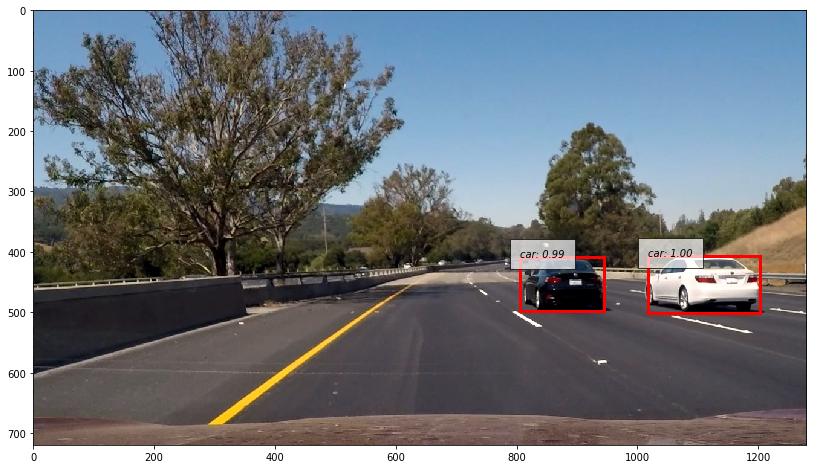

In [4]:
# Run inference on one of the test images
# Load a test image
image = utils.read_image('test6.jpg', color=True)
# Run object detection
bboxes, labels, scores = model.predict([image])
# Use Chainer's visualization method to draw bounding boxes, detected objects, and score
vis_bbox(image, bboxes[0], labels[0], scores[0], label_names=voc_bbox_label_names)

#### Time the object detection inference

In [5]:
%timeit bboxes, labels, scores = model.predict([image])

22.4 ms ± 271 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Define the pipeline

In [6]:
def filter_outliers(boxes):
    """
    Remove outliers from bounding boxes
    """
    filtered = []
    for box in boxes:
        (bot, left, top, right) = box
        # SSD model tends to detect random large boxes at left
        if abs(right - left) < 500:
            filtered.append(box)
    return np.array(filtered)

def pipeline(img):
    """
    Pipeline routine called by video processing
    """
    # Chainer images have color as axis 0 - so move around the axes
    # i.e., axes are (3,720,1280) instead of (720,1280,3)
    cimg = np.rollaxis(img, 2)
    # Do the object detection
    boxes, labels, scores = model.predict([cimg])
    
    # Filter outliers from the bounding boxes
    filtered = filter_outliers(boxes[0])

    # Copy image to draw on
    result = Image.fromarray(img)
    draw = ImageDraw.Draw(result)
    # Draw the boxes
    for (bot, left, top, right) in filtered:
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=4, fill='white')

    return np.array(result)

### Test the pipeline

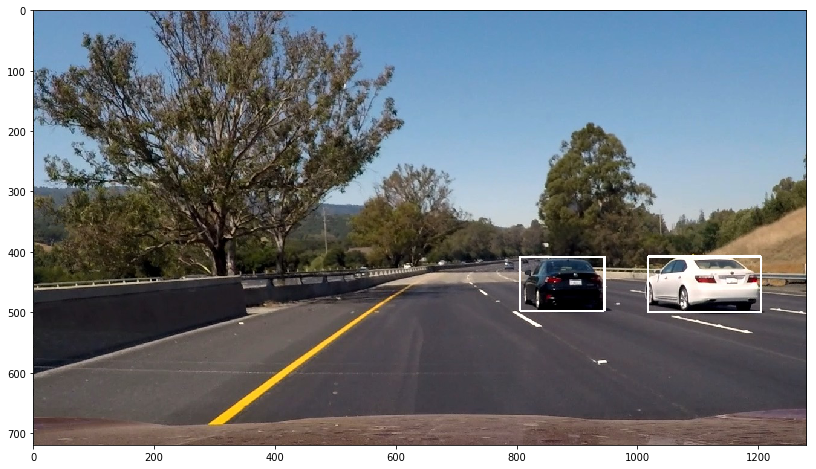

In [7]:
# Video frames are RGB images, so test pipeline withRGB image read using matplotlib
image2 = mpimg.imread('test6.jpg')
# Run pipeline
result=pipeline(image2)
# Show result
plt.imshow(result)

### Run object detection on video

In [8]:
# Set the video clip
clip = VideoFileClip('project_video.mp4')

In [9]:
# Run video processing
new_clip = clip.fl_image(pipeline)
new_clip.write_videofile('chainer_ssd_300.mp4')

[MoviePy] >>>> Building video chainer_ssd_300.mp4
[MoviePy] Writing audio in chainer_ssd_300TEMP_MPY_wvf_snd.mp3


100%|██████████| 1112/1112 [00:00<00:00, 3601.02it/s]

[MoviePy] Done.
[MoviePy] Writing video chainer_ssd_300.mp4



100%|█████████▉| 1260/1261 [00:39<00:00, 32.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: chainer_ssd_300.mp4 



In [10]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('chainer_ssd_300.mp4'))

##  SSD 512x512 model

In [11]:
model = SSD512(
    n_fg_class=len(voc_bbox_label_names),
    pretrained_model='voc0712')
model.to_gpu()

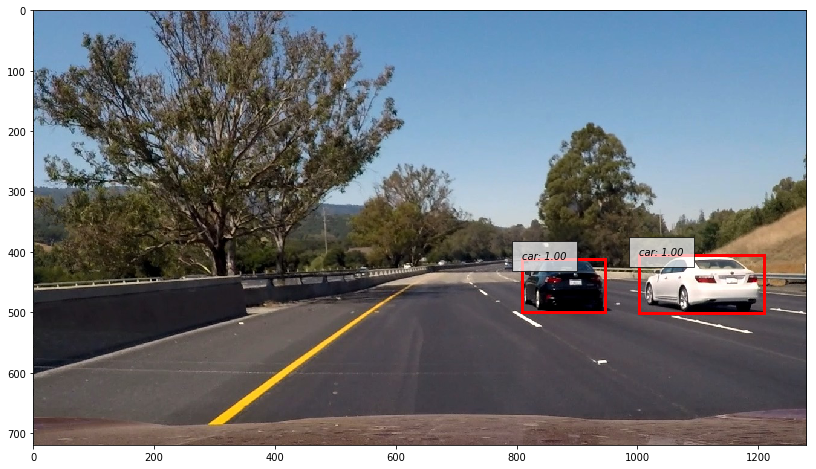

In [12]:
# Run inference on same image from before
bboxes, labels, scores = model.predict([image])
vis_bbox(image, bboxes[0], labels[0], scores[0], label_names=voc_bbox_label_names)

In [13]:
%timeit bboxes, labels, scores = model.predict([image])

37.1 ms ± 92.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Video processing

In [14]:
new_clip = clip.fl_image(pipeline)
new_clip.write_videofile('chainer_ssd_512.mp4')

[MoviePy] >>>> Building video chainer_ssd_512.mp4
[MoviePy] Writing audio in chainer_ssd_512TEMP_MPY_wvf_snd.mp3


100%|██████████| 1112/1112 [00:00<00:00, 2832.81it/s]

[MoviePy] Done.
[MoviePy] Writing video chainer_ssd_512.mp4



100%|█████████▉| 1260/1261 [01:32<00:00, 13.63it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: chainer_ssd_512.mp4 



In [15]:
HTML("""
<video width="960" height="600" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format('chainer_ssd_512.mp4'))